In [1]:
import sklearn
import os, zipfile
import sys
import matplotlib.pyplot as plt
import cv2
import pytesseract
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG19
conf = r'--oem 3'

In [2]:
local_zip = './zip/Keep babies safe.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./data/keep')
zip_ref.close()

In [3]:
image_folder = './data/keep/dataset/images/'
test_csv = './data/keep/dataset/test.csv'

# Dapatkan daftar semua file gambar dalam folder images
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
df = pd.read_csv(test_csv)

print("Daftar File Gambar:")
for image_file in image_files:
    print(os.path.join(image_folder, image_file))

Daftar File Gambar:
./data/keep/dataset/images/006a22fa50.jpg
./data/keep/dataset/images/01484e7348.jpg
./data/keep/dataset/images/015d91ab7b.jpg
./data/keep/dataset/images/01f8ce31f6.jpg
./data/keep/dataset/images/020e280221.jpg
./data/keep/dataset/images/023f2fffb5.jpg
./data/keep/dataset/images/03055302c2.jpg
./data/keep/dataset/images/03096d79f6.jpg
./data/keep/dataset/images/0313932c71.jpg
./data/keep/dataset/images/035901786e.jpg
./data/keep/dataset/images/03a8f0c877.jpg
./data/keep/dataset/images/03b046d851.jpg
./data/keep/dataset/images/03b35bb939.jpg
./data/keep/dataset/images/0446e93c6b.jpg
./data/keep/dataset/images/045619ac0e.jpg
./data/keep/dataset/images/04a8d576ee.jpg
./data/keep/dataset/images/04eb7cdb85.jpg
./data/keep/dataset/images/051f3acaca.jpg
./data/keep/dataset/images/058c3a9f96.jpg
./data/keep/dataset/images/059b8436bb.jpg
./data/keep/dataset/images/05b569c392.jpg
./data/keep/dataset/images/05b5f66700.jpg
./data/keep/dataset/images/05c384621a.jpg
./data/keep/da

In [4]:
print(f"Data dari file test.csv: \n {df.head()}")

Data dari file test.csv: 
             Image  Class_of_image  Brand_name
0  006a22fa50.jpg             NaN         NaN
1  01484e7348.jpg             NaN         NaN
2  015d91ab7b.jpg             NaN         NaN
3  01f8ce31f6.jpg             NaN         NaN
4  020e280221.jpg             NaN         NaN


In [5]:
DataFrame = {
    'photo_name' : [],
    'flattenPhoto' : [],
    'text' : [],

    }
local_weights_path = './data/keep/dataset/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
Model = tf.keras.models.Sequential()
# Model.add(tf.keras.applications.VGG19(
#     include_top = False, weights='imagenet',    pooling='avg',
# ))

vgg19_model = VGG19(include_top=False, weights=None, pooling='avg', input_shape=(224, 224, 3))
vgg19_model.load_weights(local_weights_path)


Model.add(vgg19_model)


Model.add(tf.keras.layers.Dense(units=256, activation='relu'))
Model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
Model.layers[0].trainable = False
# Print model summary
Model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20155969 (76.89 MB)
Trainable params: 131585 (514.00 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [7]:
def LoadDataAndDoEssentials(path, h, w):
    img = cv2.imread(path)
    img = cv2.resize(img, (h, w))
    ## Expanding image dims so this represents 1 sample
    img = img = np.expand_dims(img, 0)
    
    img = tf.keras.applications.resnet50.preprocess_input(img)
    extractedFeatures = Model.predict(img)
    extractedFeatures = np.array(extractedFeatures)
    DataFrame['flattenPhoto'].append(extractedFeatures.flatten())

def ReadAndStoreMyImages(path):
    list_ = os.listdir(path)

    for mem in list_:
        DataFrame['photo_name'].append(mem)
        imagePath = path + '/' + mem
        LoadDataAndDoEssentials(imagePath, 224, 224)


ReadAndStoreMyImages(image_folder)

1/1 [==============================] - 0s 312ms/step


In [8]:
Training_Feature_vector = np.array(DataFrame['flattenPhoto'], dtype = 'float64')

kmeans = KMeans(n_clusters = 2)
kmeans.fit(Training_Feature_vector)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


KMeans(n_clusters=2)

In [9]:
predictions = kmeans.labels_
NamePred = []
for mem in predictions:
 if mem == 0:
    NamePred.append('toys')
 else:
    NamePred.append('consumer_products')

In [10]:
textAns = np.array(DataFrame['text'])
realText = []
import re
for mem in textAns:
 newMem = re.sub("\s\s+", " ", mem)
 if len(newMem) == 0 or newMem == " ":
    realText.append('Unnamed')
    continue
 else:
    realText.append(str(newMem))

names = DataFrame['photo_name']
df1 = {'Image' : names,'Class_of_image' : NamePred,'Brand_name' : realText}
df = pd.DataFrame.from_dict(df1, orient='index')
df = df.transpose()
df.head(10)

Image     Class_of_image Brand_name
0  006a22fa50.jpg               toys       None
1  006a22fa50.jpg               toys       None
2  01484e7348.jpg  consumer_products       None
3  015d91ab7b.jpg               toys       None
4  01f8ce31f6.jpg               toys       None
5  020e280221.jpg               toys       None
6  023f2fffb5.jpg               toys       None
7  03055302c2.jpg               toys       None
8  03096d79f6.jpg               toys       None
9  0313932c71.jpg               toys       None

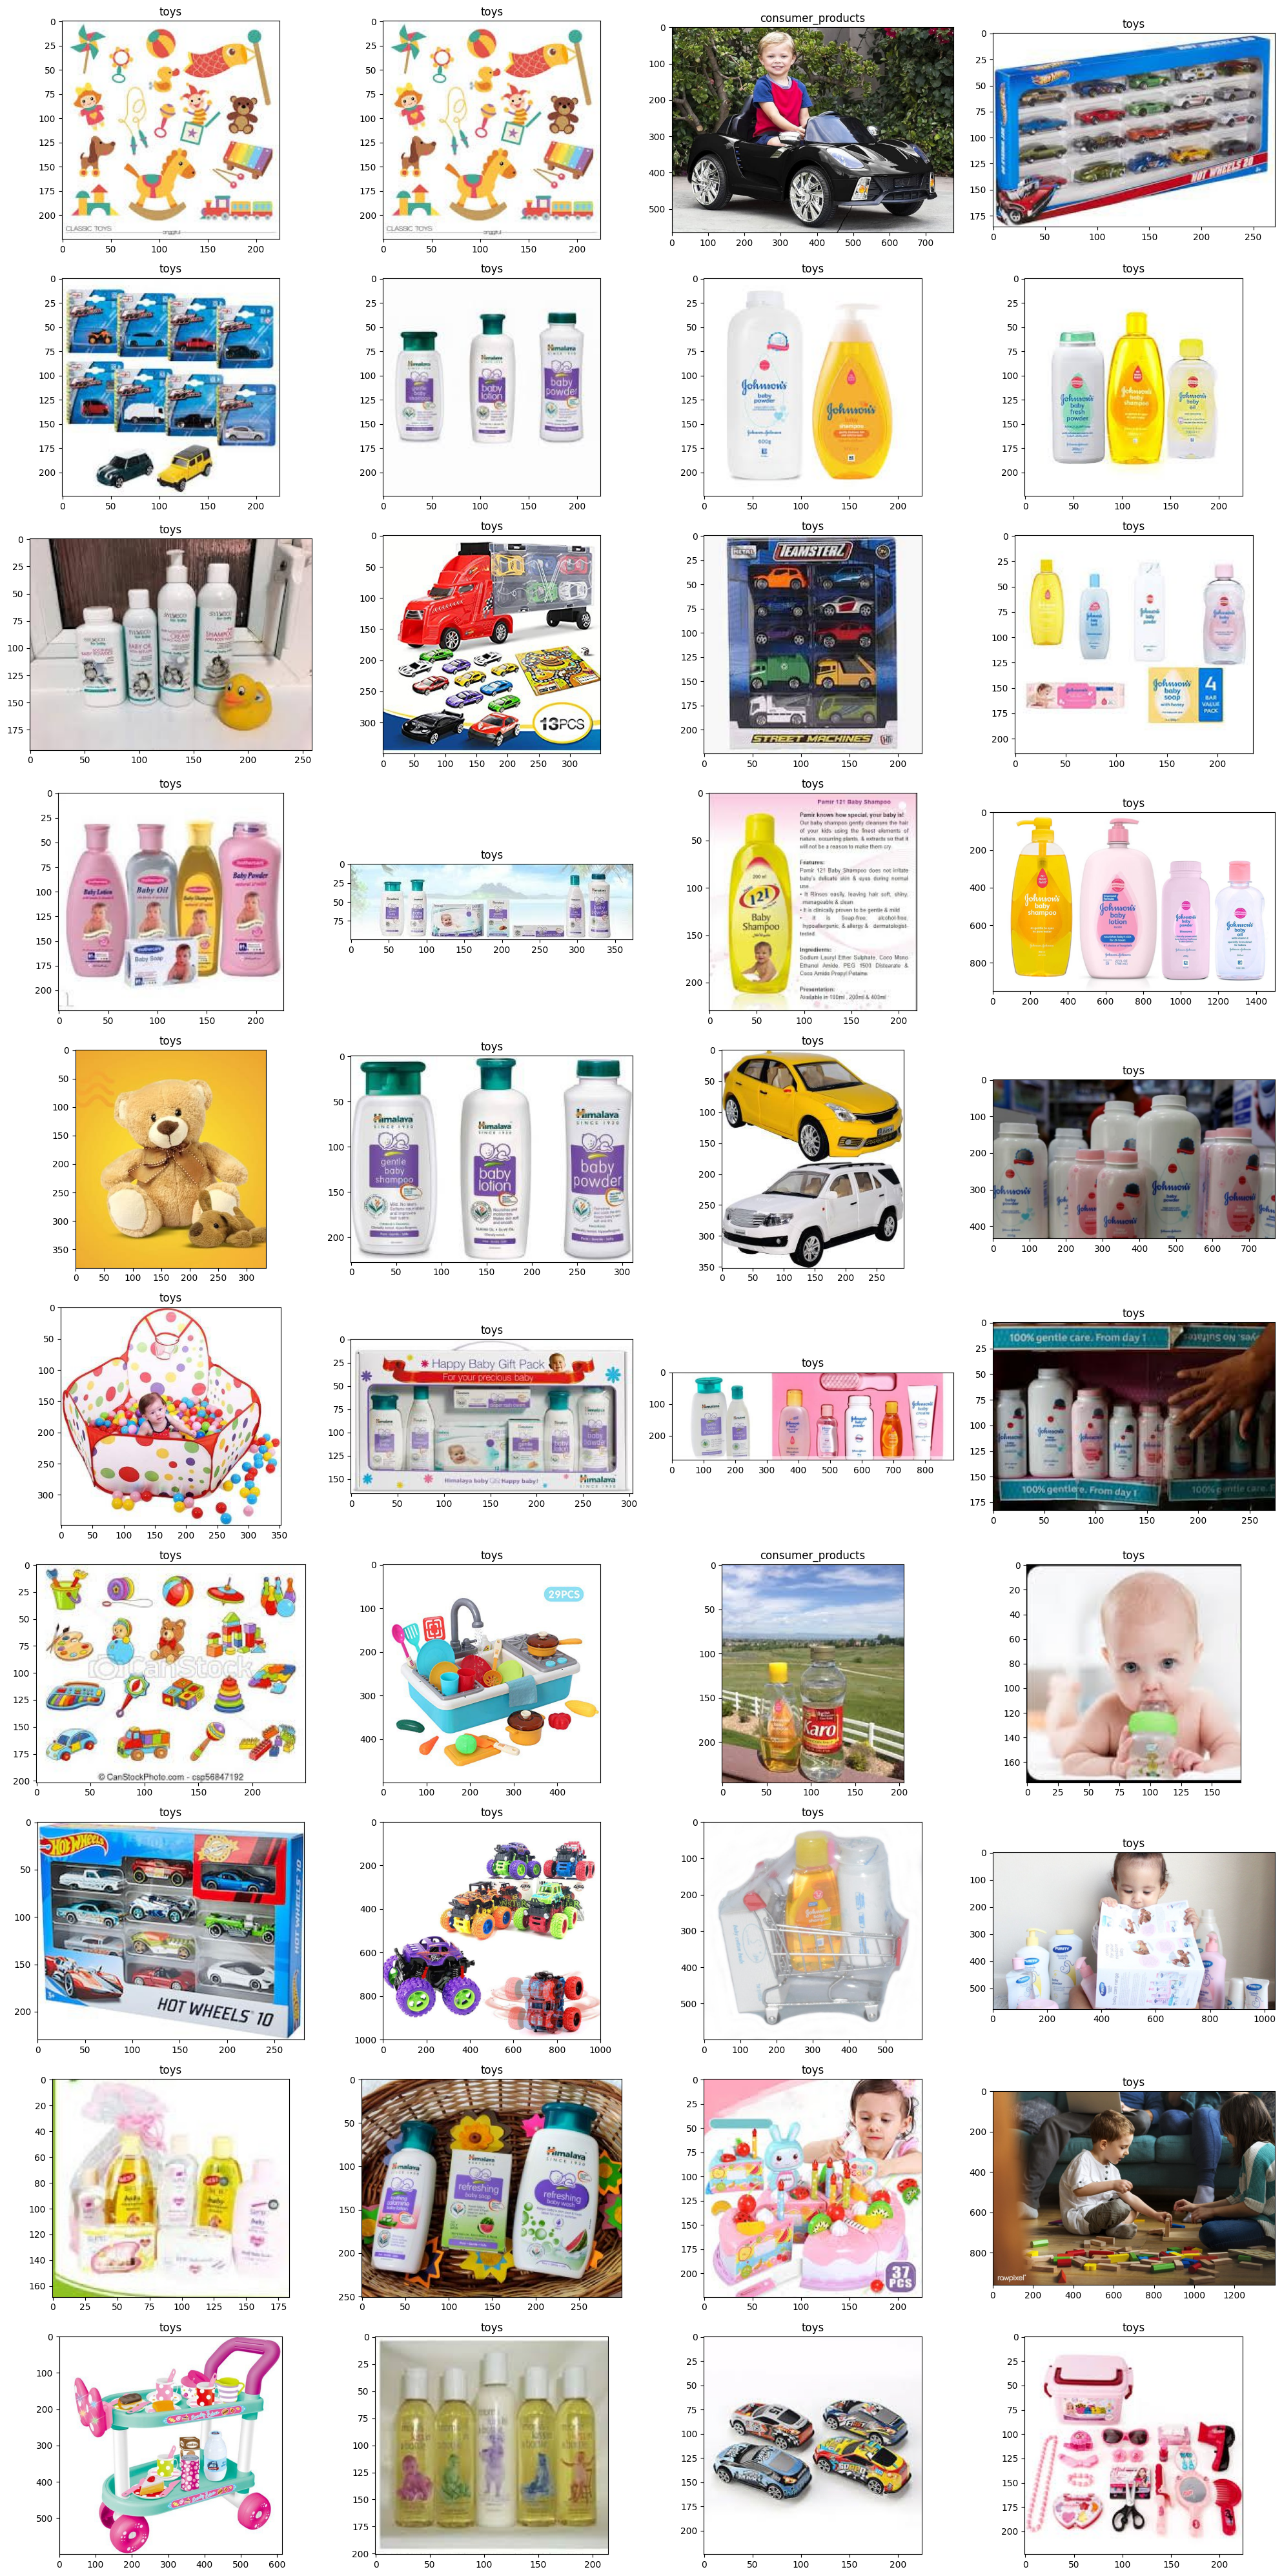

In [13]:
def display_samples(df, columns=4, rows=10):
    fig = plt.figure(figsize=(5 * columns, 4 * rows))
    
    for i in range(columns * rows):
        image_path = df.loc[i, 'Image']
        img = cv2.imread(f'./data/keep/dataset/images/{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        fig.add_subplot(rows, columns, i + 1)
        plt.title(df.loc[i, 'Class_of_image'])
        plt.imshow(img)

    plt.tight_layout()
    plt.show()

# Display the samples
display_samples(df)